## Code Description:

This is just to predict flux and indices based on number of alerts.
Note that this is to test the fermi_data_main_flux_index_prediction.py code and see how the outputs look like for a singe seed!

In [1]:
import os,sys
import numpy as np
import pandas as pd
import pyLCR
from astropy.io import fits
import pickle
import datetime
from codes_from_pylcr import *

import joblib
import glob
import matplotlib.pyplot as plt

# For training:
import xgboost as xgb

import glob


The Fermi-LAT Light Curve Repository Toolkit v0.1.0
Support Contact: Daniel Kocevski (daniel.kocevski@nasa.gov)


In [2]:
if os.path.isdir("../Model_predictions/test_one_seed_case")==False:
    os.makedirs("../Model_predictions/test_one_seed_case")
os.chdir("../Model_predictions/test_one_seed_case")

In [3]:
flux_factor_for_alert= 50 #50


In [4]:
num_alerts_files = glob.glob(f'../../Fermi_sample/alerts_per_year_flux_factor_{flux_factor_for_alert}/num_alerts_per_year_file_*')
alerts_per_bin_files = glob.glob(f'../../Fermi_sample/alerts_per_year_flux_factor_{flux_factor_for_alert}/alerts_flux_data_per_year_file_*')

In [5]:
src_names=[]
for path_name in num_alerts_files:
    src_names.append(path_name[-21:][:-4])

In [6]:
leave_number_indices=-6

# Starting prediction!

In [7]:
# Make new feature files or sue old ones:
make_feature_files=True

# Set Debug Flag
debug_this=False


seed=1234
if os.path.isdir(f'seed_{seed}_flux_factor_{flux_factor_for_alert}/')!=True:
    os.mkdir(f'seed_{seed}_flux_factor_{flux_factor_for_alert}/')

In [8]:
# To run all sources, comment out: if src_names[src_index]!="4FGL_J0001.2-0747"
# Same for everything
for src_index in range(len(src_names)):
    if make_feature_files==False:
        continue
    if src_names[src_index]!="4FGL_J0001.2-0747": #"4FGL_J0118.3-6008":
        continue
    
    alerts_data = np.load(alerts_per_bin_files[src_index])
    all_times = alerts_data[0]  # MJD times
    all_flux = np.log10(alerts_data[1])   # Flux values
    all_index = alerts_data[2]  # Index values
    
    # Create DataFrame with flux and index
    df = pd.DataFrame({
        '#MJD': all_times,
        'flux': all_flux,
        'index': all_index
    })

    df.set_index('#MJD', inplace=True)
    
    print(f"\n{'='*70}")
    print(f"Processing: {src_names[src_index]}")
    print(f"{'='*70}")
    print(f"Total data points: {len(df)}")
    print(f"Non-zero flux points: {(df['flux'] > 0).sum()} ({100*(df['flux'] > 0).sum()/len(df):.1f}%)")
    print(f"Non-zero index points: {(df['index'] != 0).sum()} ({100*(df['index'] != 0).sum()/len(df):.1f}%)")
    
    if debug_this==True:
        df.plot(figsize=(10,5))

    # ---- CREATE FEATURES - USE PERCENTAGE CHANGE FOR FLUX ----
    batch_df = pd.DataFrame(index=df.index)
    
    # Add lagging Features 
    batch_df['flux_lag_1'] = df['flux'].shift(1) # Prediction 1 Use numdays: -1 day 0-1 = 1
    batch_df['flux_lag_2'] = df['flux'].shift(2) # Prediction 2 Use numdays: -2 day 0-2 = 2
    batch_df['flux_lag_3'] = df['flux'].shift(3) # Prediction 3 Use numdays: -3 day 0-4 = 3
    batch_df['flux_lag_4'] = df['flux'].shift(4) # 
    batch_df['flux_lag_5'] = df['flux'].shift(5) # 
    batch_df['flux_lag_6'] = df['flux'].shift(6) # 
  
    batch_df['index_lag_1'] = df['index'].shift(1) # Prediction 1 Use numdays: -1 day 0-1 = 1
    batch_df['index_lag_2'] = df['index'].shift(2) # Prediction 2 Use numdays: -2 day 0-2 = 2
    batch_df['index_lag_3'] = df['index'].shift(3) # Prediction 3 Use numdays: -3 day 0-4 = 3
    batch_df['index_lag_4'] = df['index'].shift(4) # 
    batch_df['index_lag_5'] = df['index'].shift(5) # 
    batch_df['index_lag_6'] = df['index'].shift(6) # 
    
    # Rolling statistics
    batch_df['flux_rolling_mean_7'] = df['flux'].rolling(window=7).mean().round(2)
    batch_df['flux_rolling_std_7'] = df['flux'].rolling(window=7).std().round(2)
    
    batch_df['index_rolling_mean_7'] = df['index'].rolling(window=7).mean().round(2)
    batch_df['index_rolling_std_7'] = df['index'].rolling(window=7).std().round(2)
    
    # Lagging target variable
    batch_df['flux_target_1d'] = df['flux'].shift(-1) # Next day
    batch_df['index_target_1d'] = df['index'].shift(-1) # Next day

    batch_df['flux_target_2d'] = df['flux'].shift(-2) # Next day
    batch_df['index_target_2d'] = df['index'].shift(-2) # Next day
    
    
    # Drop NaN rows
    batch_df = batch_df.dropna()
    
    if len(batch_df) < 5:
        print(f"Warning: {src_names[src_index]} has insufficient data")
        #continue
    
    # Create feature and target dataframes
    directory = f'seed_{seed}_flux_factor_{flux_factor_for_alert}/feature_store'
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    id_val = "v3"
    
    # Features for FLUX prediction
    flux_features_cols = [
        'flux_lag_1', 'flux_lag_2','flux_lag_3','flux_lag_4','flux_lag_5','flux_lag_6', 
        'flux_rolling_mean_7','flux_rolling_std_7', 
        'index_lag_1', 'index_lag_2','index_lag_3','index_lag_4','index_lag_5','index_lag_6', 
        'index_rolling_mean_7','index_rolling_std_7'
    ]
    flux_features_df = batch_df[flux_features_cols].copy()
    flux_features_df.to_csv(f'{directory}/{src_names[src_index]}_flux_features_{id_val}.csv')
    
    # Targets for FLUX prediction
    flux_targets_df = batch_df[['flux_target_1d','flux_target_2d']].copy()
    flux_targets_df.to_csv(f'{directory}/{src_names[src_index]}_flux_targets_{id_val}.csv')
    
    # Features for INDEX prediction
    index_features_cols = [
        'index_lag_1', 'index_lag_2','index_lag_3','index_lag_4','index_lag_5','index_lag_6', 
        'index_rolling_mean_7','index_rolling_std_7',
        'flux_lag_1', 'flux_lag_2','flux_lag_3','flux_lag_4','flux_lag_5','flux_lag_6', 
        'flux_rolling_mean_7','flux_rolling_std_7'
    ]
    index_features_df = batch_df[index_features_cols].copy()
    index_features_df.to_csv(f'{directory}/{src_names[src_index]}_index_features_{id_val}.csv')
    
    # Targets for INDEX prediction
    index_targets_df = batch_df[['index_target_1d', 'index_target_2d']].copy()
    index_targets_df.to_csv(f'{directory}/{src_names[src_index]}_index_targets_{id_val}.csv')
    
    print(f"Created feature files for {src_names[src_index]} - {len(batch_df)} samples")



Processing: 4FGL_J0001.2-0747
Total data points: 101
Non-zero flux points: 0 (0.0%)
Non-zero index points: 101 (100.0%)
Created feature files for 4FGL_J0001.2-0747 - 93 samples


In [9]:
#df.plot(figsize=(10,5))

In [10]:
# Check correlation matrix. 
# Ideally we want low correlation between features, but high correlation between features and target
# features are lgs and target are target_nd 
# This is one of the things you need to do to improve the model, slice the data so there are more better correlations (cloer to 1)

#corr = batch_df.corr()
#corr.style.background_gradient(cmap='coolwarm')

In [11]:
# Make new feature files or sue old ones:
make_training_files=True

In [12]:
def train_model(fermi_src, directory, id_val, model_type='flux'):
    """
    Train XGBoost model - 
    """
    if fermi_src != "4FGL_J0001.2-0747":#  "4FGL_J0118.3-6008":
        return
    
    feature_file = f'{directory}/{fermi_src}_{model_type}_features_{id_val}.csv'
    target_file = f'{directory}/{fermi_src}_{model_type}_targets_{id_val}.csv'
    
    X_train = pd.read_csv(feature_file)
    X_train.set_index('#MJD', inplace=True)
    
    targets_df = pd.read_csv(target_file)
    targets_df.set_index('#MJD', inplace=True)
    
    # Use all data except last points for training
    X_train_mod = X_train.head(leave_number_indices)
    targets_df_mod = targets_df.head(leave_number_indices)
    
    # Train on target (percentage for flux, absolute for index)
    y_train = targets_df_mod[f'{model_type}_target_1d']
    
    # Remove any remaining NaN values
    #mask = ~(X_train_mod.isna().any(axis=1) | y_train.isna())
    #X_train_mod = X_train_mod[mask]
    #y_train = y_train[mask]
    
    if len(X_train_mod) < 5:
        print(f"Warning: {fermi_src} has insufficient data for {model_type} training")
        #return
    
    print(f"\n{'='*70}")
    print(f"Training {model_type.upper()} model for {fermi_src}")
    print(f"  Target: {'target_1d'}")
    print(f"{'='*70}")
    print(f"Training samples: {len(X_train_mod)}")
    print(f"Target statistics:")
    print(f"  Min:  {y_train.min():.6f}")
    print(f"  Max:  {y_train.max():.6f}")
    print(f"  Mean: {y_train.mean():.6f}")
    print(f"  Std:  {y_train.std():.6f}")
    
    # Model parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.3,
        'max_depth': 3,
        'min_child_weight': 1,
        'subsample': 0.9,
        'colsample_bytree': 0.9,
        'gamma': 0,
        'reg_alpha': 0.05,
        'reg_lambda': 0.5,
        'tree_method': 'hist',
    }
    
    dtrain = xgb.DMatrix(data=X_train_mod, label=y_train)
    
    # Cross-validation
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=200,
        nfold=3,
        early_stopping_rounds=30,
        metrics='rmse',
        as_pandas=True,
        seed=seed,
        verbose_eval=False
    )
    
    optimal_rounds = max(cv_results['test-rmse-mean'].idxmin() + 1, 20)
    best_rmse = cv_results['test-rmse-mean'].min()
    
    print(f"\nCross-validation results:")
    print(f"  Best RMSE: {best_rmse:.6f}")
    print(f"  Optimal boost rounds: {optimal_rounds}")
    
    # Train final model
    final_model = xgb.XGBRegressor(
        n_estimators=optimal_rounds,
        **params,
        random_state=seed
    )
    
    final_model.fit(X_train_mod, y_train)
    
    # Check predictions
    train_pred = final_model.predict(X_train_mod)
    pred_std = np.std(train_pred)
    pred_range = train_pred.max() - train_pred.min()
    pred_mean = np.mean(train_pred)
    
    print(f"\nTraining predictions:")
    print(f"  Min:   {train_pred.min():.6f}")
    print(f"  Max:   {train_pred.max():.6f}")
    print(f"  Mean:  {pred_mean:.6f}")
    print(f"  Std:   {pred_std:.6f}")
    print(f"  Range: {pred_range:.6f}")
    
    
    # Save model
    if not os.path.isdir(f'seed_{seed}_flux_factor_{flux_factor_for_alert}/models'):
        os.mkdir(f'seed_{seed}_flux_factor_{flux_factor_for_alert}/models')
    
    filename = f'seed_{seed}_flux_factor_{flux_factor_for_alert}/models/{fermi_src}_{model_type}_model_{id_val}.pkl'
    joblib.dump(final_model, filename)
    
    print(f"\n✓ Saved model: {filename}")
    print(f"{'='*70}\n")
    
    del dtrain, cv_results


In [13]:
# Train models
make_training_files = True
id_val = "v3"
directory = f'seed_{seed}_flux_factor_{flux_factor_for_alert}/feature_store'

if make_training_files:
    for src_index in range(len(src_names)):
        if src_names[src_index] != "4FGL_J0001.2-0747":#  "4FGL_J0118.3-6008":
            continue
        
        print(f"\n{'='*60}")
        print(f"Training models for {src_names[src_index]}")
        print(f"{'='*60}")
        
        train_model(src_names[src_index], directory, id_val, model_type='flux')
        train_model(src_names[src_index], directory, id_val, model_type='index')



Training models for 4FGL_J0001.2-0747

Training FLUX model for 4FGL_J0001.2-0747
  Target: target_1d
Training samples: 87
Target statistics:
  Min:  -6.962574
  Max:  -5.772113
  Mean: -6.544009
  Std:  0.207764

Cross-validation results:
  Best RMSE: 0.211350
  Optimal boost rounds: 20

Training predictions:
  Min:   -6.880142
  Max:   -5.823899
  Mean:  -6.543056
  Std:   0.171393
  Range: 1.056243

✓ Saved model: seed_1234/models/4FGL_J0001.2-0747_flux_model_v3.pkl


Training INDEX model for 4FGL_J0001.2-0747
  Target: target_1d
Training samples: 87
Target statistics:
  Min:  2.090000
  Max:  5.000000
  Mean: 3.855747
  Std:  0.859591

Cross-validation results:
  Best RMSE: 0.881123
  Optimal boost rounds: 20

Training predictions:
  Min:   2.593585
  Max:   4.991171
  Mean:  3.854978
  Std:   0.702347
  Range: 2.397586

✓ Saved model: seed_1234/models/4FGL_J0001.2-0747_index_model_v3.pkl



In [14]:
#targets_df = pd.read_csv(f'{directory}/{src_names[0]}_targets_{id}.csv')
#targets_df.set_index('#MJD', inplace=True) #This replaces the index with the MJD value
#targets_df_mod = targets_df.head(10) # save some rows for later 
#targets_df_mod
#len(targets_df)


# Now we Predict!

In [15]:
import matplotlib as mpl

font = {'size'   : 25}
mpl.rc('font', **font) 

In [16]:
if os.path.isdir(f'seed_{seed}_flux_factor_{flux_factor_for_alert}/predictions')!=True:
    os.mkdir(f'seed_{seed}_flux_factor_{flux_factor_for_alert}/predictions')


In [17]:
def make_predictions_plot(src_names, directory, id_val, model_type='flux'):
    """
    Make predictions and reconstruct absolute values
    """
    
    for src_index in range(len(src_names)):
        src = src_names[src_index]
        if src != "4FGL_J0001.2-0747":#  "4FGL_J0118.3-6008":
            continue
        
        try:
            print(f"\n{'='*70}")
            print(f"Making {model_type.upper()} predictions for {src}")
            print(f"{'='*70}")
            
            # Load features
            features_df = pd.read_csv(f'{directory}/{src}_{model_type}_features_{id_val}.csv')
            features_df.set_index('#MJD', inplace=True)
            #features_df = features_df.head(leave_number_indices)
            features_df = features_df.dropna()
            
            # Load model and predict 
            model_file = f'seed_{seed}_flux_factor_{flux_factor_for_alert}/models/{src}_{model_type}_model_{id_val}.pkl'
            model = joblib.load(model_file)
            predicted_val = model.predict(features_df)
            
            print(f"\nPredicted Val statistics:")
            print(f"  Min:   {predicted_val.min():.6f}")
            print(f"  Max:   {predicted_val.max():.6f}")
            print(f"  Mean:  {predicted_val.mean():.6f}")
            print(f"  Std:   {predicted_val.std():.6f}")
            
            
            # Load targets
            targets_df = pd.read_csv(f'{directory}/{src}_{model_type}_targets_{id_val}.csv')
            targets_df.set_index('#MJD', inplace=True)
            
            
            # Create results dataframe
            predictions_df = pd.DataFrame({
                f'{model_type}_predicted': predicted_val
            }, index=features_df.index)
            
            result_df = predictions_df.join(targets_df, how='inner')
            print(result_df)
            
            # Split train/test
            train_df = result_df.head(leave_number_indices)
            test_df = result_df.tail(-leave_number_indices)
            
            
            # Create plot
            fig = plt.figure(figsize=(14, 8), dpi=150)
            ax = plt.subplot()
            
            if model_type=='flux':
                # Plot training data
                ax.plot(train_df.index.values[1:], 10**(train_df[f'{model_type}_target_1d'].values[:-1]), "-o", 
                    color="blue", linewidth=2, markersize=4, label="Training Data", alpha=0.7)
                ax.plot(train_df.index.values[1:], 10**(train_df[f'{model_type}_predicted'].values[:-1]), "--s", 
                    color="cyan", linewidth=2, markersize=4, label="Training Predictions", alpha=0.7)
            
                # Plot test data
                if len(test_df) > 0:
                    ax.plot(test_df.index.values[1:], 10**(test_df[f'{model_type}_target_1d'].values[:-1]), "-o", 
                        color="black", linewidth=2, markersize=6, label="Test Data", alpha=0.9)
                    ax.plot(test_df.index.values[1:], 10**(test_df[f'{model_type}_predicted'].values[:-1]), "--s", 
                        color="red", linewidth=2, markersize=6, label="Test Predictions", alpha=0.9)
            else:
                # Plot training data
                ax.plot(train_df.index.values[1:], train_df[f'{model_type}_target_1d'].values[:-1], "-o", 
                    color="blue", linewidth=2, markersize=4, label="Training Data", alpha=0.7)
                ax.plot(train_df.index.values[1:], train_df[f'{model_type}_predicted'].values[:-1], "--s", 
                    color="cyan", linewidth=2, markersize=4, label="Training Predictions", alpha=0.7)
            
                # Plot test data
                if len(test_df) > 0:
                    ax.plot(test_df.index.values[1:], test_df[f'{model_type}_target_1d'].values[:-1], "-o", 
                        color="black", linewidth=2, markersize=6, label="Test Data", alpha=0.9)
                    ax.plot(test_df.index.values[1:], test_df[f'{model_type}_predicted'].values[:-1], "--s", 
                        color="red", linewidth=2, markersize=6, label="Test Predictions", alpha=0.9)
            
            plt.xlabel("Time (MJD)", fontweight='bold')
            plt.ylabel(f"{model_type.capitalize()} Value", fontweight='bold')
            plt.title(f"{src} - {model_type.upper()} Prediction", 
                      fontweight='bold')
            plt.legend(loc='best')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.yscale("log")
            #plt.xscale("log")
            
            plt.savefig(f'seed_{seed}_flux_factor_{flux_factor_for_alert}/predictions/{src}_{model_type}_prediction_{id_val}.pdf', 
                       bbox_inches="tight")
            plt.show()
            
            
        except Exception as e:
            print(f"ERROR processing {src} ({model_type}): {str(e)}")
            import traceback
            traceback.print_exc()
            continue




Making FLUX predictions for 4FGL_J0001.2-0747

Predicted Val statistics:
  Min:   -6.880142
  Max:   -5.823899
  Mean:  -6.541471
  Std:   0.167900
              flux_predicted  flux_target_1d  flux_target_2d
#MJD                                                        
55456.499988       -6.623796       -6.623423       -6.543634
55484.499988       -6.535521       -6.543634       -6.600326
55512.499988       -6.611515       -6.600326       -6.540608
55568.499988       -6.546087       -6.540608       -6.889410
55785.499988       -6.824194       -6.889410       -6.610834
...                      ...             ...             ...
60510.499954       -6.327049       -6.542118       -6.630784
60524.499954       -6.585610       -6.630784       -6.519993
60545.499954       -6.646227       -6.519993       -6.497573
60727.499954       -6.574176       -6.497573       -6.404504
60818.499954       -6.501793       -6.404504       -6.430626

[93 rows x 3 columns]


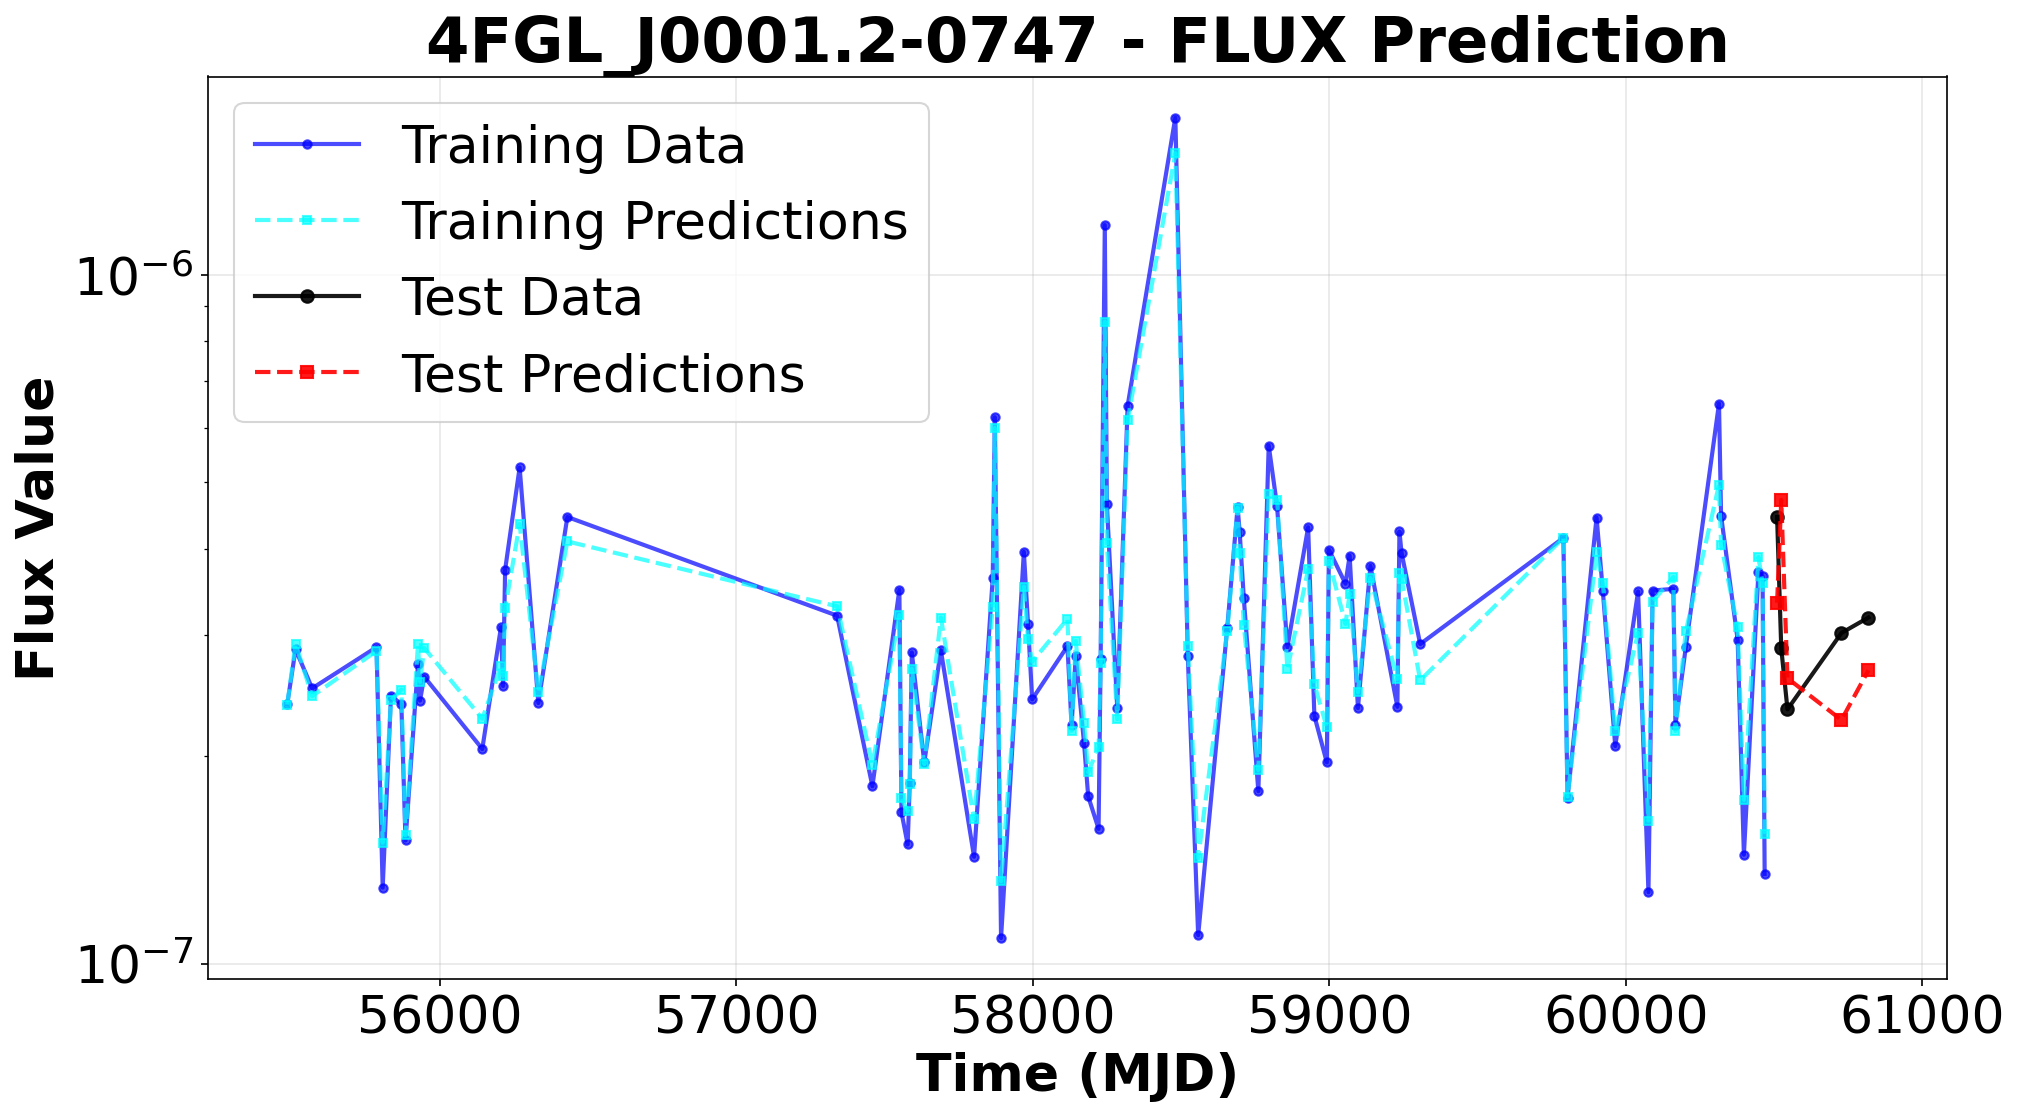


Making INDEX predictions for 4FGL_J0001.2-0747

Predicted Val statistics:
  Min:   2.593585
  Max:   5.359893
  Mean:  3.876964
  Std:   0.701366
              index_predicted  index_target_1d  index_target_2d
#MJD                                                           
55456.499988         2.992374             2.95             3.36
55484.499988         3.439172             3.36             3.55
55512.499988         3.600081             3.55             5.00
55568.499988         4.831473             5.00             3.00
55785.499988         3.270950             3.00             4.56
...                       ...              ...              ...
60510.499954         5.359893             3.01             3.47
60524.499954         3.684930             3.47             5.00
60545.499954         3.669436             5.00             3.02
60727.499954         4.107858             3.02             4.26
60818.499954         3.803290             4.26             4.33

[93 rows x 3 columns

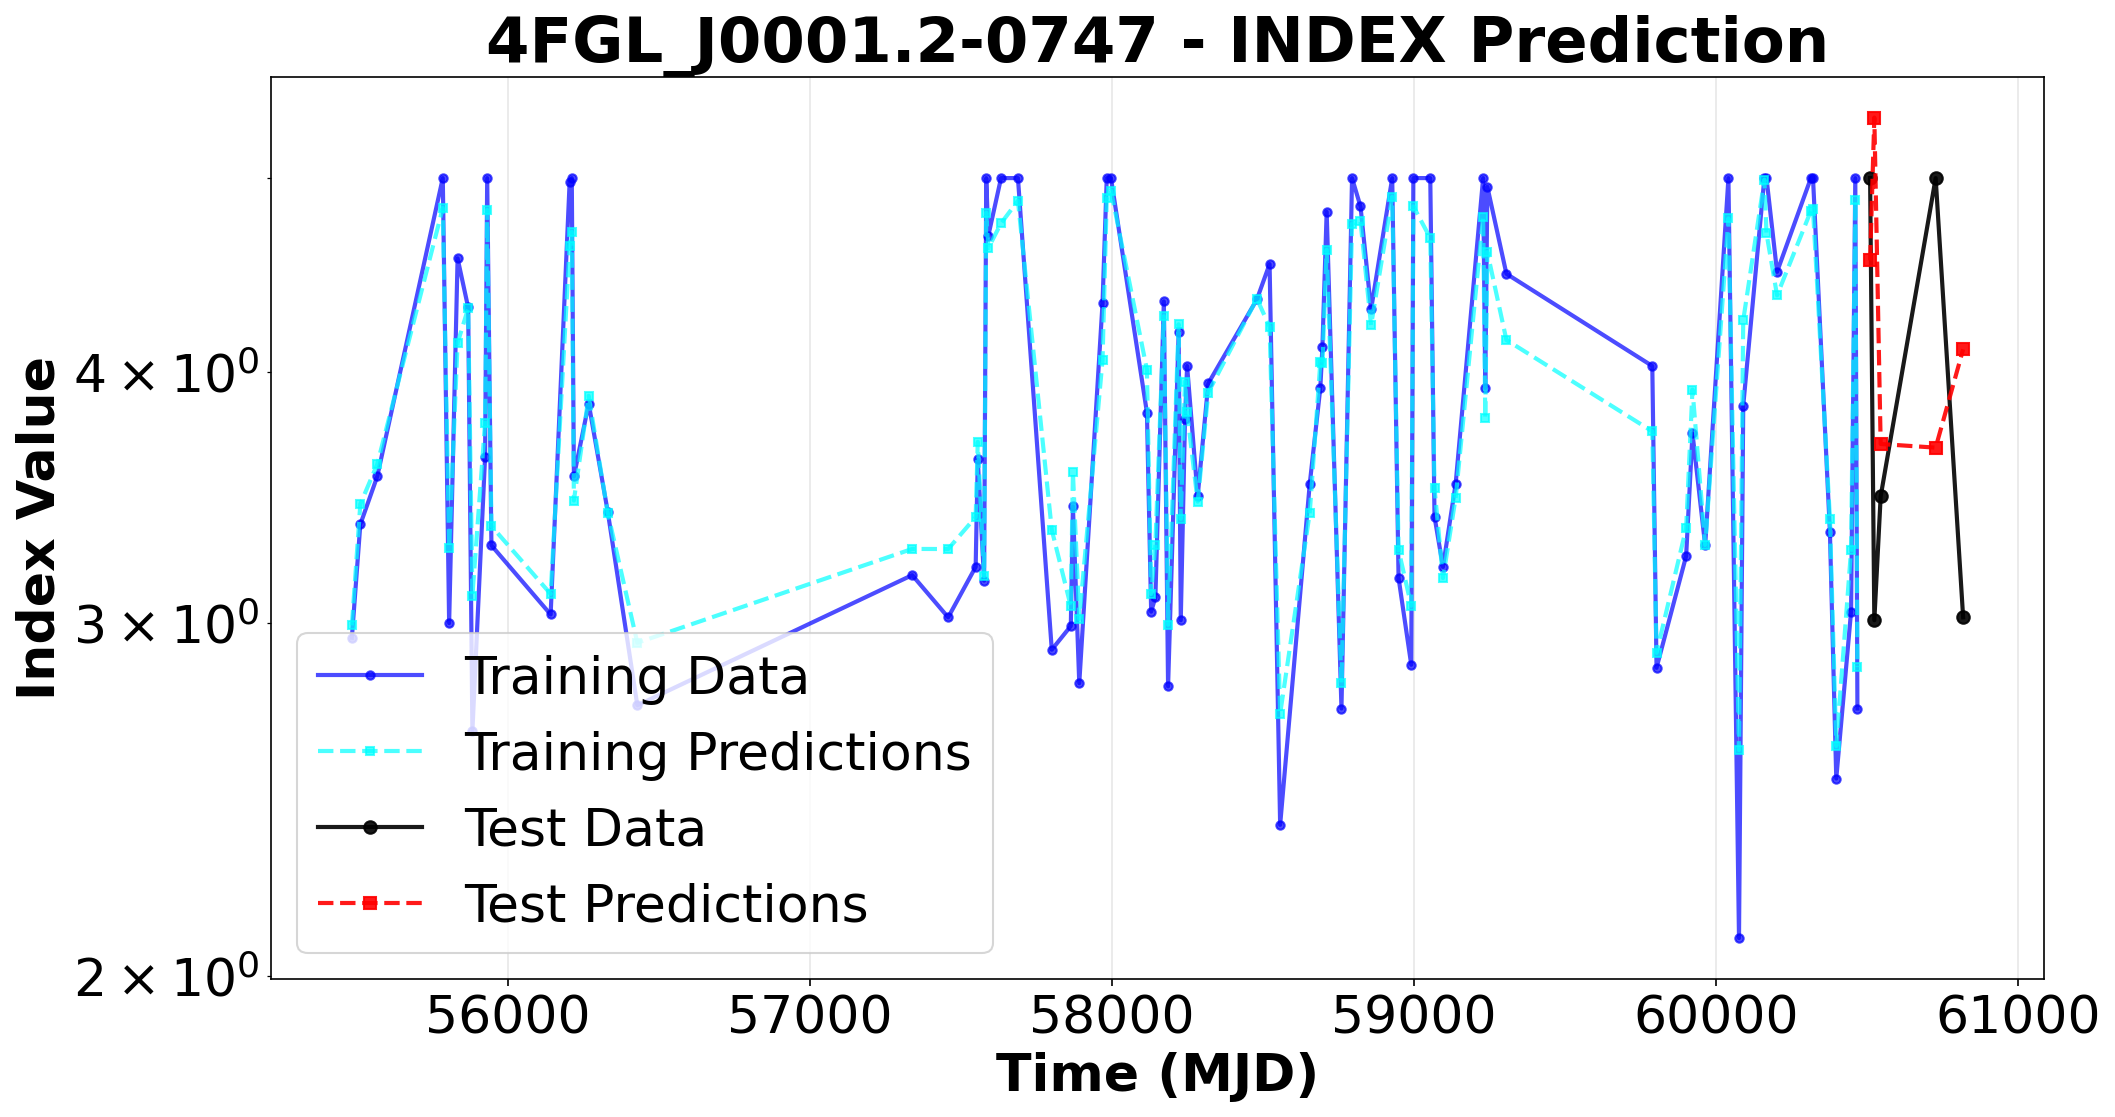


All predictions completed!


In [18]:
# Make predictions for both flux and index
make_predictions_plot(src_names, directory, id_val, model_type='flux')
make_predictions_plot(src_names, directory, id_val, model_type='index')

print("\nAll predictions completed!")